In [795]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 10)

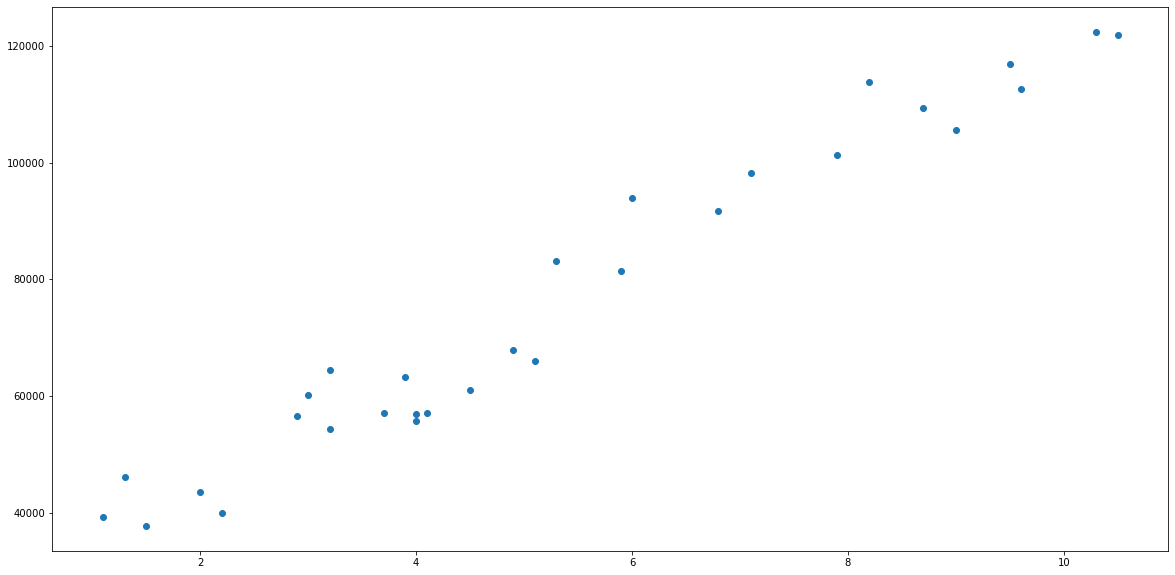

In [796]:
data = pd.read_csv('Salary_Data.csv')
years = data['YearsExperience']
salary = data['Salary']
plt.plot(years, salary, 'o')

In [797]:
def draw_row(points):
    res = points[-1]

    fig, (ax1, ax2) = plt.subplots(1, 2)
    x = np.linspace(0, 10, 100)
    ax1.plot(years, salary, 'o')
    ax1.plot(x, res[0] * x + res[1])

    t = np.linspace(-5000, 30000, 100)
    X = np.meshgrid(t, t)
    ax2.contour(X[0], X[1], f(X), levels=sorted([f(p) for p in points] + list(np.linspace(-1, 1, 100))))
    ax2.plot(points[:, 0], points[:, 1], 'o-', color='red')


def draw_normalized(points):
    res = points[-1]

    fig, (ax1, ax2) = plt.subplots(1, 2)
    x = np.linspace(-2, 2, 100)
    ax1.plot(normalized_exp, normalized_salary, 'o')
    ax1.plot(x, res[0] * x + res[1])

    t = np.linspace(-1, 2, 100)
    X = np.meshgrid(t, t)
    ax2.contour(X[0], X[1], f(X), levels=sorted([f(p) for p in points] + list(np.linspace(-1, 1, 100))))
    ax2.plot(points[:, 0], points[:, 1], 'o-', color='red')

$\sum_{i=0}^{29} (x_0 \times years_i + x_1 - salary_i)^2$

In [798]:
def f(x):
    res = 0
    for i in range(30):
        res += (x[0] * years[i] + x[1] - salary[i]) ** 2
    return res

In [799]:
def partial(f, i, x):
    h = 1e-3
    x[i] = x[i] + h
    right = f(x)
    x[i] = x[i] - 2 * h
    left = f(x)
    x[i] = x[i] + h
    return (right - left) / (2 * h)


def grad(f, x):
    return [partial(f, i, x) for i in range(len(x))]


def const_lr(n, start):
    return start


def exp_lr(n, start):
    k = 0.01
    return start * np.exp(-k * n)


In [800]:
def gd(f, lr, start, lr_strategy=const_lr, epoch=20):
    x = start
    points = np.zeros((epoch, 2))
    points[0] = x
    for i in range(1, epoch):
        x = x - lr_strategy(i, lr) * np.array(grad(f, x))
        points[i] = x

    return points

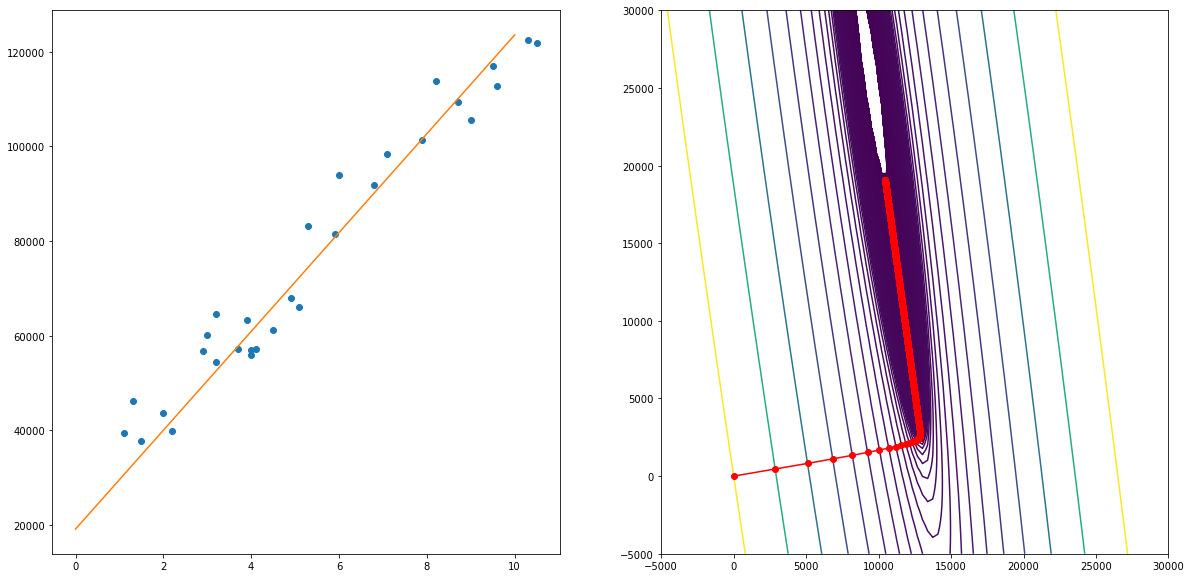

In [801]:
points = gd(f, 0.0001, start=[1, 1], epoch=1000)
draw_row(points)

In [802]:
def partial(f, i, x, ii):
    h = 1e-3
    x[i] = x[i] + h
    right = f(x, ii)
    x[i] = x[i] - 2 * h
    left = f(x, ii)
    x[i] = x[i] + h
    return (right - left) / (2 * h)


def grad(f, x, ii):
    return [partial(f, i, x, ii) for i in range(len(x))]


def single_sum(x, i):
    return (x[0] * years[i] + x[1] - salary[i]) ** 2


def stoch_grad(x):
    i = random.randint(0, 29)
    return grad(single_sum, x, i)


def sgd(f, lr, start, lr_strategy=exp_lr, epoch=20):
    x = start
    points = np.zeros((epoch, 2))
    points[0] = x
    for i in range(1, epoch):
        x = x - lr_strategy(i, lr) * np.array(stoch_grad(x))
        points[i] = x

    return points

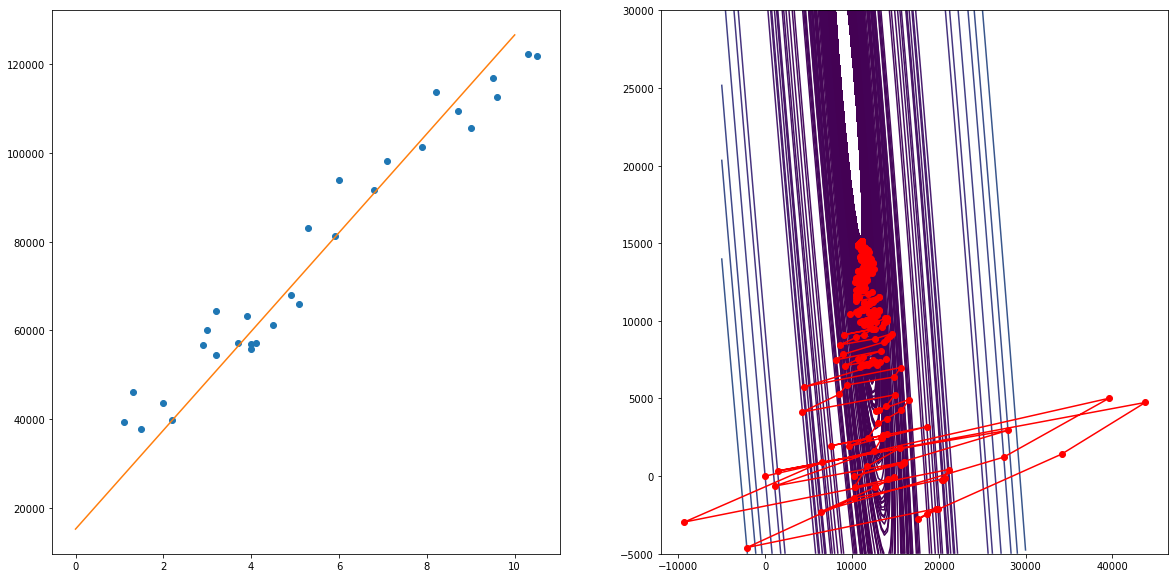

In [803]:
points = sgd(f, 0.025, start=[1, 1], epoch=1000)
draw_row(points)

In [804]:
import random


def partial(f, i, x, idxs):
    h = 1e-3
    x[i] = x[i] + h
    right = f(x, idxs)
    x[i] = x[i] - 2 * h
    left = f(x, idxs)
    x[i] = x[i] + h

    return (right - left) / (2 * h)


def grad(f, x, idxs):
    return [partial(f, i, x, idxs) for i in range(len(x))]


def pp2(x, idxs):
    sum = 0
    for i in idxs:
        sum += (x[0] * years[i] + x[1] - salary[i]) ** 2
    return sum


def minibatch_grad(x, batch):
    idxs = [random.randint(0, 29) for p in range(0, batch)]
    return grad(pp2, x, idxs)


def minibatch_sgd(f, lr, start, lr_strategy=exp_lr, epoch=20, batch=1):
    x = start
    points = np.zeros((epoch, 2))
    points[0] = x
    for i in range(1, epoch):
        x = x - lr_strategy(i, lr) * np.array(minibatch_grad(x, batch))
        points[i] = x

    return points

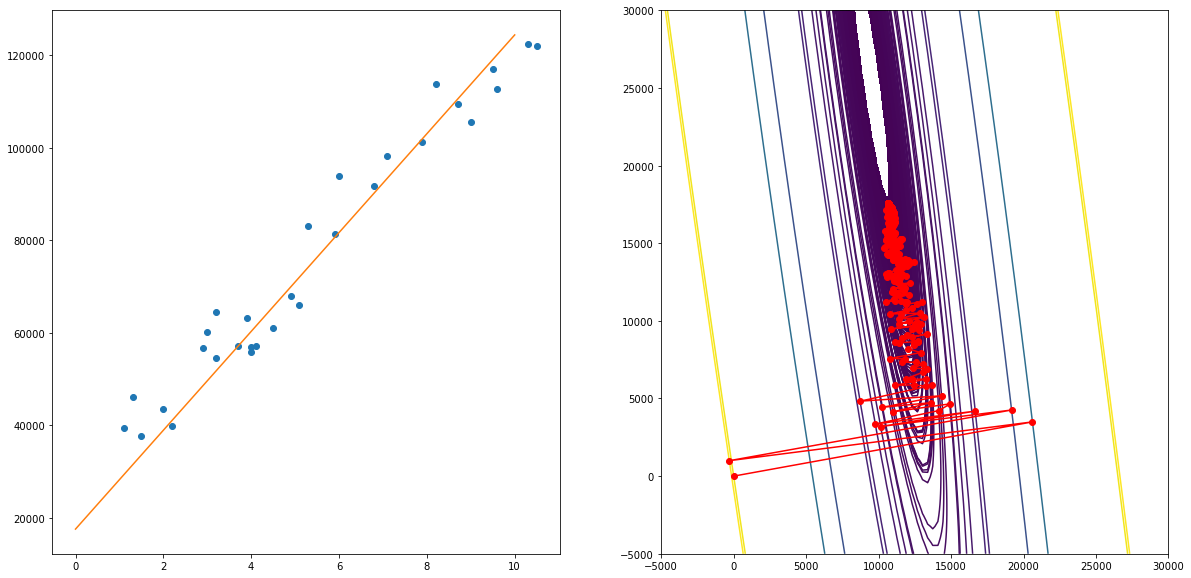

In [805]:
points = minibatch_sgd(f, 0.005, start=[1, 1], epoch=1000, batch=5)
draw_row(points)

# 2

In [806]:
avg_exp = years.mean()
dev_exp = years.std()

avg_salary = salary.mean()
dev_salary = salary.std()

In [807]:
normalized_exp = [(e - avg_exp) / dev_exp for e in years]
normalized_salary = [(e - avg_salary) / dev_salary for e in salary]

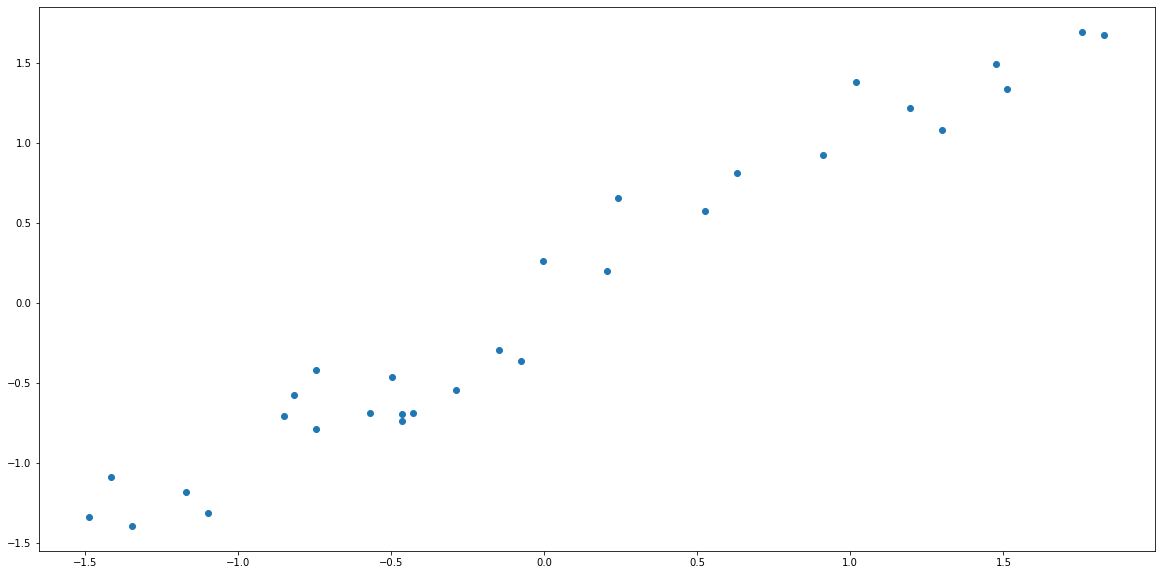

In [808]:
plt.plot(normalized_exp, normalized_salary, 'o')

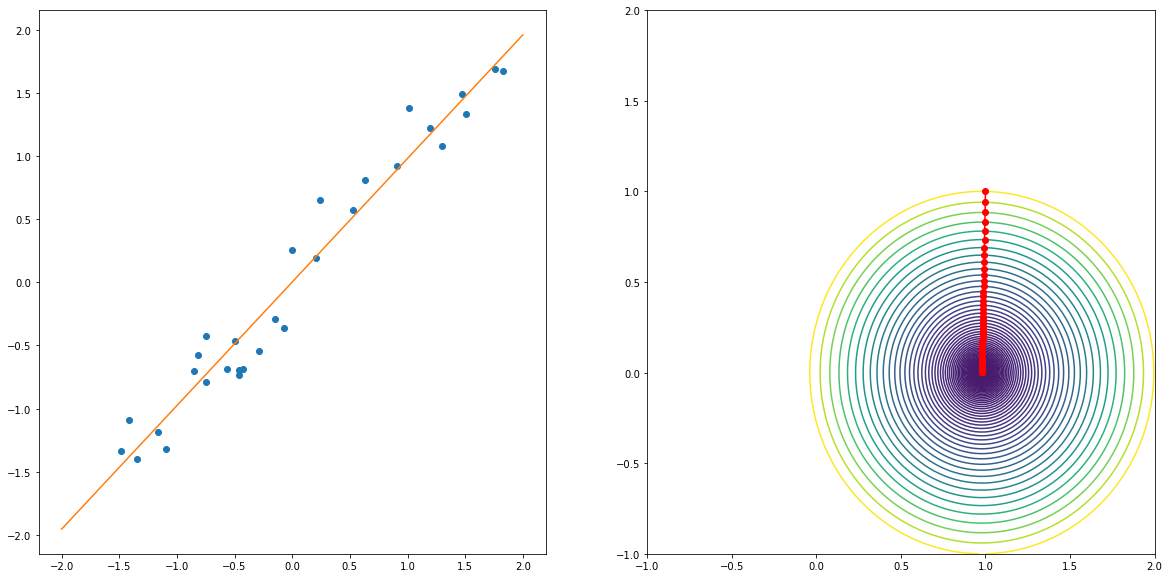

In [809]:
def f(x):
    res = 0
    for i in range(30):
        res += (x[0] * normalized_exp[i] + x[1] - normalized_salary[i]) ** 2
    return res


def partial(f, i, x):
    h = 1e-3
    x[i] = x[i] + h
    right = f(x)
    x[i] = x[i] - 2 * h
    left = f(x)
    x[i] = x[i] + h
    return (right - left) / (2 * h)


def grad(f, x):
    return [partial(f, i, x) for i in range(len(x))]


def gd(f, lr, start, lr_strategy=const_lr, epoch=20):
    x = start
    points = np.zeros((epoch, 2))
    points[0] = x
    for i in range(1, epoch):
        x = x - lr_strategy(i, lr) * np.array(grad(f, x))
        points[i] = x

    return points


points = gd(f, 0.001, start=[1, 1], epoch=100)

draw_normalized(points)

In [810]:
def partial(f, i, x, ii):
    h = 1e-3
    x[i] = x[i] + h
    right = f(x, ii)
    x[i] = x[i] - 2 * h
    left = f(x, ii)
    x[i] = x[i] + h
    return (right - left) / (2 * h)


def grad(f, x, ii):
    return [partial(f, i, x, ii) for i in range(len(x))]


def pp(x, i):
    return (x[0] * normalized_exp[i] + x[1] - normalized_salary[i]) ** 2


def stoch_grad(x):
    i = random.randint(0, 29)
    return grad(pp, x, i)


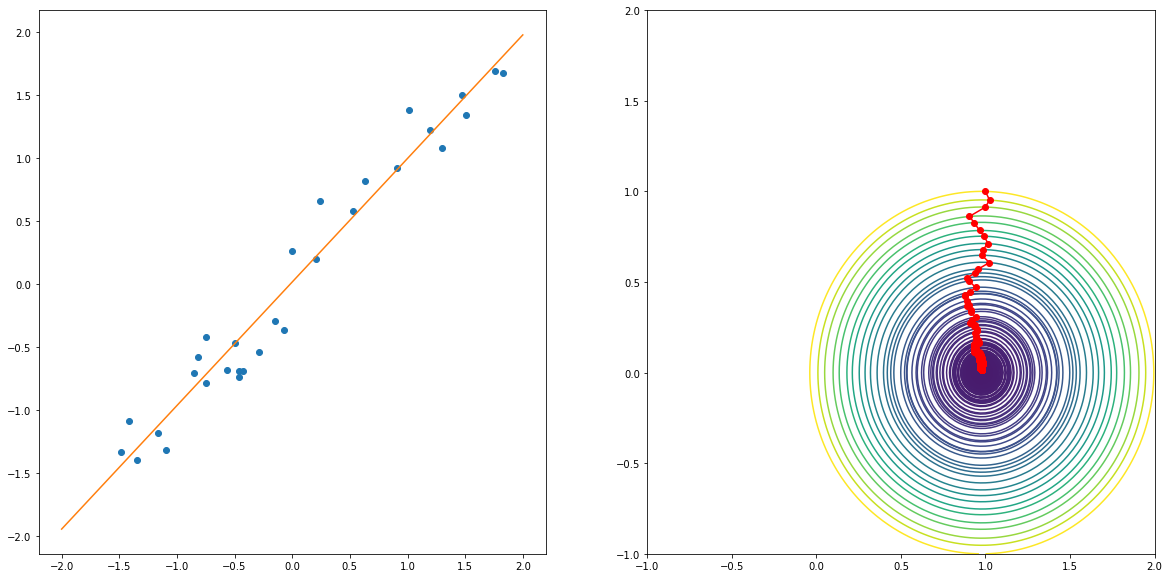

In [811]:
def sgd(f, lr, start, lr_strategy=exp_lr, epoch=20):
    x = start
    points = np.zeros((epoch, 2))
    points[0] = x
    for i in range(1, epoch):
        x = x - lr_strategy(i, lr) * np.array(stoch_grad(x))
        points[i] = x

    return points


points = sgd(f, 0.025, start=[1, 1], epoch=1000)
draw_normalized(points)

## Задание 3

### Momentum

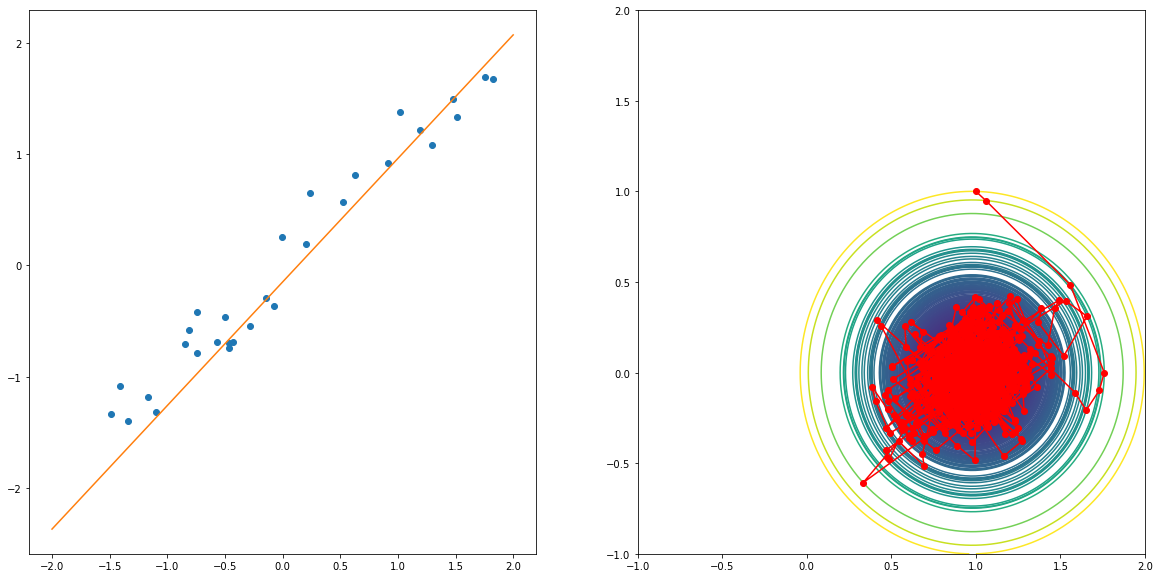

In [812]:
def sgd_with_momentum(f, b, lr, start, lr_strategy=exp_lr, epoch=20):
    x = start
    points = np.zeros((epoch, 2))
    prev_gr = np.array([0, 0])
    points[0] = x
    for i in range(1, epoch):
        new_grad = np.array(stoch_grad(x))
        new_step = b * prev_gr + lr_strategy(i, lr) * new_grad

        x = x - new_step
        prev_gr = new_grad
        points[i] = x

    return points


points = sgd_with_momentum(f, b=0.2, lr=0.025, start=[1, 1], epoch=1000)
draw_normalized(points)

## Nesterov momentum

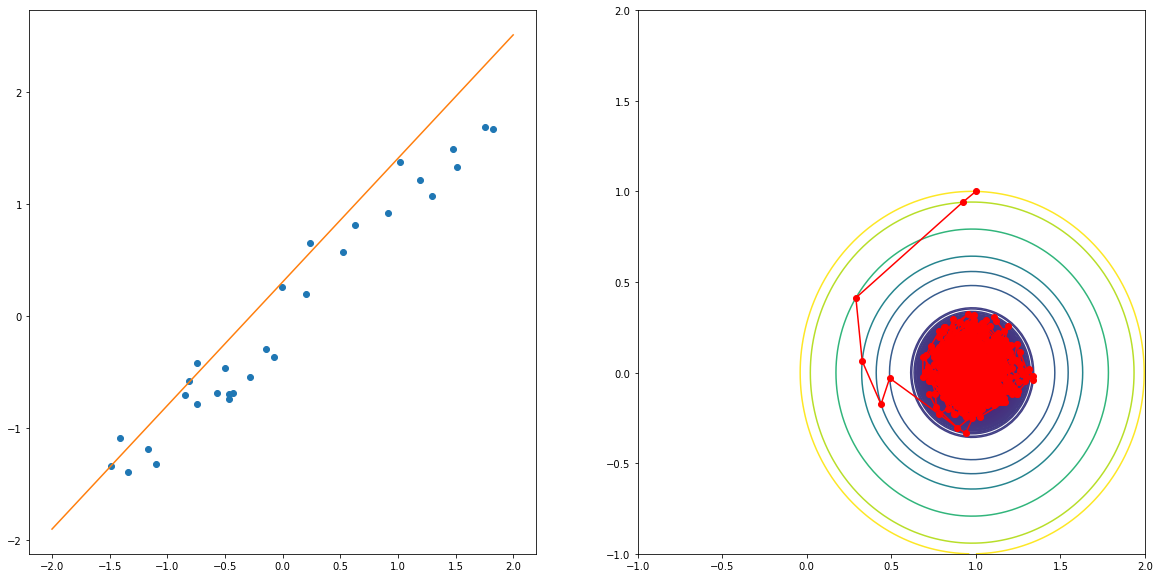

In [813]:
def sgd_with_nesterov_momentum(f, b, lr, start, lr_strategy=exp_lr, epoch=20):
    x = start
    points = np.zeros((epoch, 2))
    prev_gr = np.array([0, 0])
    points[0] = x
    for i in range(1, epoch):
        new_grad = np.array(stoch_grad(x - b * prev_gr))
        new_step = b * prev_gr + lr_strategy(i, lr) * new_grad

        x = x - new_step
        prev_gr = new_grad
        points[i] = x

    return points


points = sgd_with_nesterov_momentum(f, b=0.2, lr=0.025, start=[1, 1], epoch=1000)
draw_normalized(points)

## AdaGrad

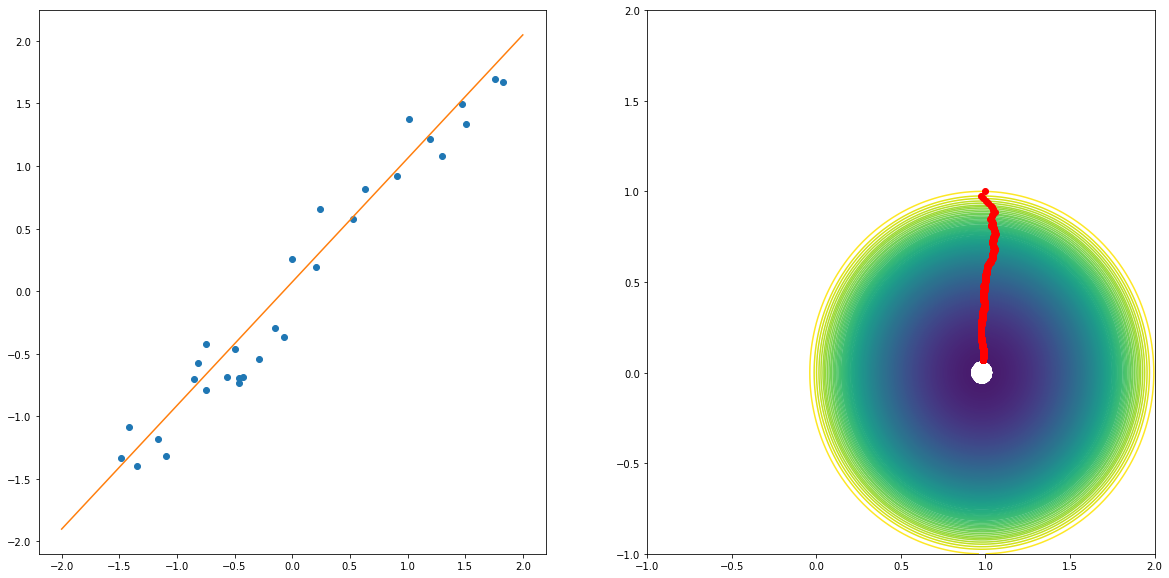

In [814]:
def adagrad(f, lr, start, lr_strategy=exp_lr, epoch=20):
    x = start
    s = np.array([0, 0])
    points = np.zeros((epoch, 2))
    points[0] = x
    for i in range(1, epoch):
        gr = np.array(stoch_grad(x))
        s = s + np.power(gr, 2)
        x = x - lr_strategy(i, lr) / np.sqrt(s) * gr
        points[i] = x

    return points


points = adagrad(f, lr=0.025, lr_strategy=const_lr, start=[1, 1], epoch=1000)
draw_normalized(points)

## RMSProp

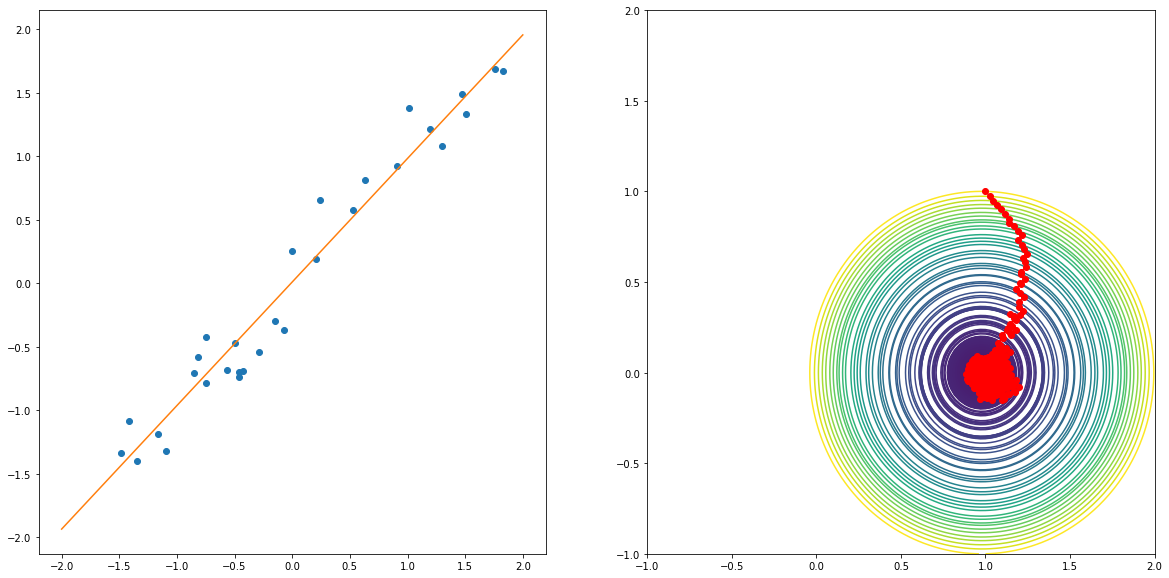

In [815]:
def rmsprop(f, b, lr, start, lr_strategy=exp_lr, epoch=20):
    x = start
    s = np.array([0, 0])
    points = np.zeros((epoch, 2))
    points[0] = x
    for i in range(1, epoch):
        gr = np.array(stoch_grad(x))
        s = b * s + (1 - b) * np.power(gr, 2)
        x = x - lr_strategy(i, lr) / np.sqrt(s) * gr
        points[i] = x

    return points


points = rmsprop(f, lr=0.025, b=0.2, lr_strategy=const_lr, start=[1, 1], epoch=1000)
draw_normalized(points)

## Adam

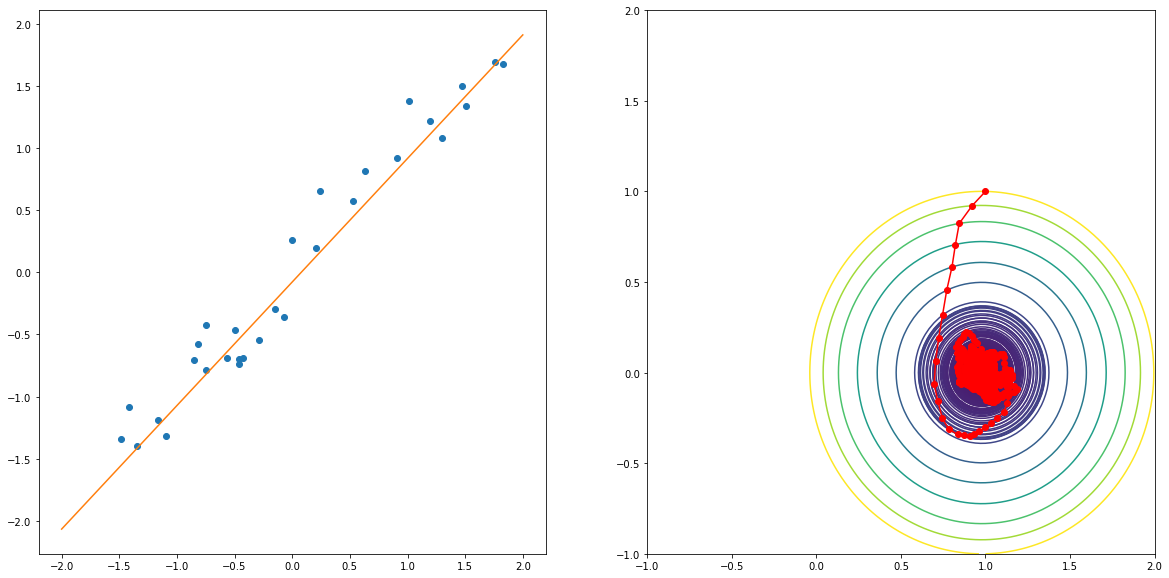

In [816]:
def adam(f, b1, b2, lr, start, lr_strategy=exp_lr, epoch=20):
    x = start
    s = np.array([0, 0])
    points = np.zeros((epoch, 2))

    prev_grad = np.array([0, 0])
    prev_v = np.array([0, 0])

    points[0] = x
    for i in range(1, epoch):
        gr = np.array(stoch_grad(x))
        g = b1 * prev_grad + (1 - b1) * gr
        v = b2 * prev_v + (1 - b2) * np.power(gr, 2)

        # g_norm = g / (1 - b1 ** (i - 1) + 10**(-8))
        # v_norm = v / (1 - b2 ** (i - 1) + 10**(-8))

        x = x - lr_strategy(i, lr) * g / np.sqrt(v)
        prev_v = v
        prev_grad = g

        points[i] = x

    return points


points = adam(f, lr=0.025, b1=0.9, b2=0.999, lr_strategy=const_lr, start=[1, 1], epoch=1000)
draw_normalized(points)